# ResNet-18 Classification 
This notebook demonstrates the biometric classification problem as applied to the DEAP dataset using the OMA algorithm. It is setup to run without modification except for the initial pathlib, which you should change to match the location this repositiory was cloned on your local machine.

The fastai library really only works on Linux, so watch out for that.

As this model makes use of the preprocessed data which was downloaded with the repositiory, so no preprocessing is needed.

Remember, you can take a detailed look at any function using ```?? pathlib.Path``` or ```?? learn.recorder.plot_losses()``` etc etc

Setup: Javascript and ipynb stuff

In [24]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

## Load Functions

In [26]:
from fastai.vision import *
import os
import numpy as np
import pandas as pd
import pickle
import warnings; warnings.simplefilter('ignore')

## Load Original Data Labels

Change this .Path to match your repository. 

In [27]:
path=pathlib.Path('/media/tris/tris_files/github/SysID_EEGdynamics/src/data/preprocessed/OMA_DEAP') #CHANGE ME
path

PosixPath('/media/tris/tris_files/github/SysID_EEGdynamics/src/data/preprocessed/OMA_DEAP')

In [51]:
df = pd.read_csv(path/'labels_proc.csv') #load file name and subject information into a pandas dataframe
df.tail()

,file_name,subject_label
1275,S32T36,32
1276,S32T37,32
1277,S32T38,32
1278,S32T39,32
1279,S32T40,32


## Data loader
fastai (which is a modified pytorch) data loader

In [29]:
src = (ImageList.from_csv(path, 'labels_proc.csv', folder='heatmaps', suffix='.png') #It's a bunch of images, the labels are in a csv, the images are in the heatmaps folder, and they are .png
       .split_by_rand_pct(0.2) # the validation set is a randomly selected group that is 20% of the samples in the total dataset
       .label_from_df(cols=['subject_label'],label_cls=CategoryList)) #get labels from the subject_label column in the data frame we loaded above

In [30]:
tfms=[] #set transforms and augmentation for the data, we choose to do no augmentation here, which is a lever we could improve are model with, but choose not to

In [31]:
data = (src.transform(tfms, size=200) #apply the transforms to the images and resize to 200*200 pixels
        .databunch(bs=4).normalize()) #each batch should have 4 images in it. Limited by RAM You could increase this with a beefier machine, or decrease it for something with a small GPU.

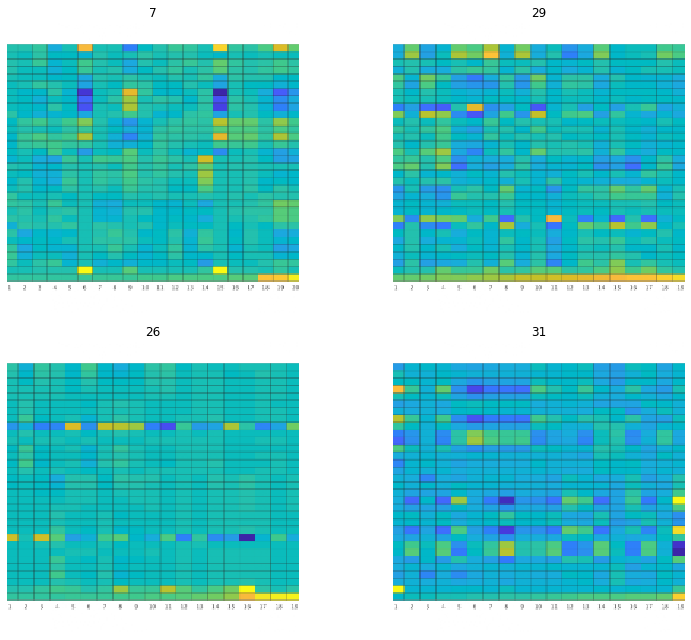

In [32]:
data.show_batch(rows=4, figsize=(12,9)) # show an example batch

## Setup Network

Having specified the data base, choose a network to train.

cnn_learner is a generic function for all fastai's CNN's. First pass the databunch positionally. Choose the model architecture, ```models.resnet18``` here, which is a ResNet architecture with 18 layers. Metrics are generally non-differentiable functions that have some bearing on model performance. RSME is also very common. 

In [33]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [34]:
learn.summary() #print out the selected model

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 100, 100]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 100, 100]       128        True      
______________________________________________________________________
ReLU                 [64, 100, 100]       0          False     
______________________________________________________________________
MaxPool2d            [64, 50, 50]         0          False     
______________________________________________________________________
Conv2d               [64, 50, 50]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 50, 50]         128        True      
______________________________________________________________________
ReLU                 [64, 50, 50]         0          False     
___________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


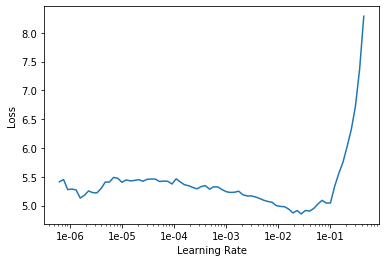

In [35]:
learn.lr_find()
learn.recorder.plot()

## Train last layers

In [36]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,3.827333,2.367518,0.359375,00:14
1,2.456262,1.251470,0.656250,00:13
2,1.713535,0.943750,0.734375,00:13
3,1.256444,0.733793,0.808594,00:13
4,1.068383,0.739478,0.781250,00:13


In [37]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.930184,0.725179,0.789062,00:13
1,0.968521,0.632266,0.812500,00:14
2,0.828987,0.523034,0.851562,00:13
3,0.820929,0.508652,0.843750,00:13
4,0.613360,0.512385,0.828125,00:13


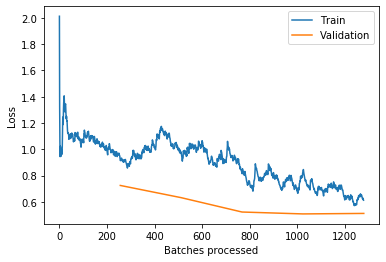

In [38]:
learn.recorder.plot_losses()

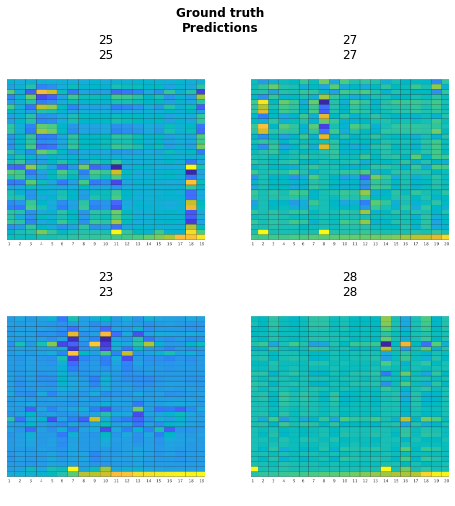

In [39]:
learn.show_results()

## Train the whole network

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


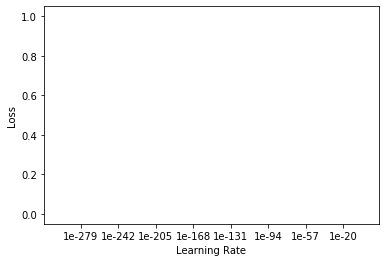

In [40]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [41]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.268229,1.515651,0.585938,00:14
1,1.497349,0.826141,0.734375,00:14
2,0.895387,0.259874,0.921875,00:14
3,0.511394,0.127149,0.957031,00:14
4,0.331651,0.101276,0.968750,00:14


In [42]:
learn.fit_one_cycle(1, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.299473,0.106135,0.988281,00:14


These results are good. There's a couple more levers we could pull, but don't here:
- Increase the size of the images after this initial training
- Another few epochs after freezing the middle layers

For computational and demonstration reasons, we'll just train the last layer a few more epochs, but the DMD and EEGMMI models use some of the more advanced methods.

In [44]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.310021,0.094884,0.976562,00:14
1,0.418648,0.099386,0.976562,00:14
2,0.476784,0.077725,0.984375,00:14
3,0.331139,0.114423,0.972656,00:14
4,0.351247,0.112887,0.976562,00:14


## Interpret and Results

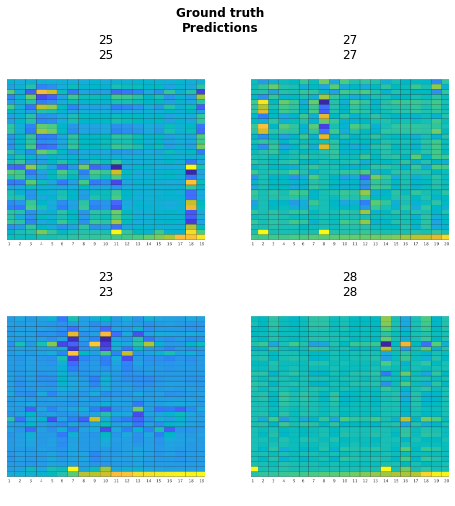

In [45]:
learn.show_results()

In [46]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [47]:
interp.confusion_matrix()

array([[13,  0,  0,  0, ...,  0,  0,  0,  0],
       [ 0, 10,  0,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  3,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  0,  9, ...,  0,  0,  0,  0],
       ...,
       [ 0,  0,  0,  0, ...,  4,  0,  0,  0],
       [ 0,  0,  0,  0, ...,  0,  8,  0,  0],
       [ 0,  0,  0,  0, ...,  0,  0,  8,  0],
       [ 0,  0,  0,  0, ...,  0,  0,  0,  7]])

In [48]:
learn.data.stats

[tensor([0.2968, 0.7080, 0.7957]), tensor([0.3562, 0.1699, 0.1777])]

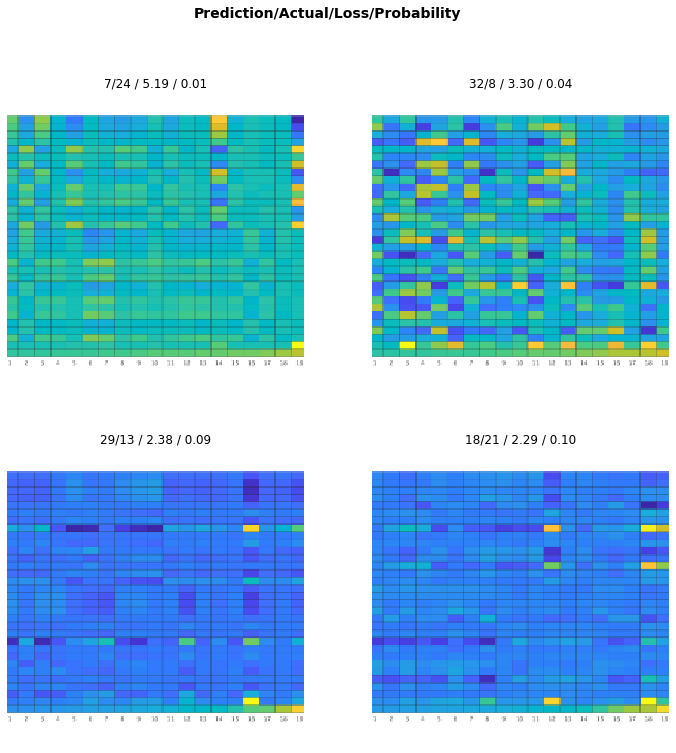

In [49]:
interp.plot_top_losses(4)

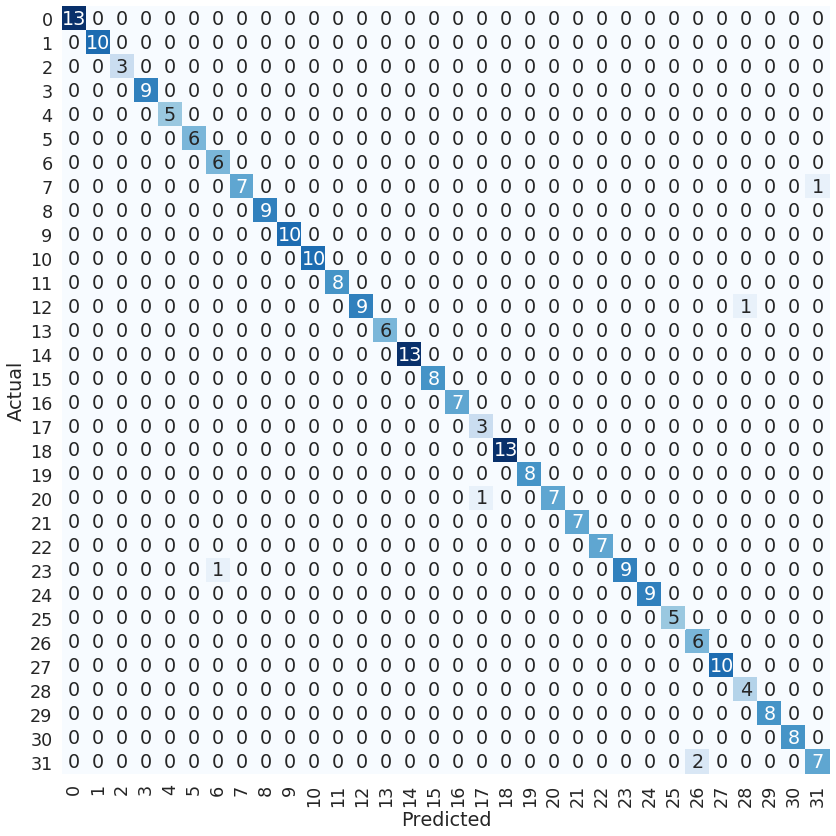

In [50]:
import seaborn as sn
array = interp.confusion_matrix()
df_cm = pd.DataFrame(array, index = [i for i in range(32)],
                  columns = [i for i in range(32)])
plt.figure(figsize = (12,12))

sn.set(font_scale=1.6)
ax=sn.heatmap(df_cm, annot=True, cbar=False, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()